# RL and Advanced DL: Домашнее задание 1

## Часть первая, с блекджеком и стратегиями

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


1. Попробуем простую стратегию. Здесь просто запускаем цикл c условием для агента с дилером и ждем - особо ничего не придумаешь :)

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm

C:\Users\MishaYuliaAlina\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Класс для сбора статистики

In [2]:
class BlackjackPlayer:
    def __init__(self):
        self.points = list()
        self.hands = list()
        self.reward = list()
        
    def clear(self):
        self.points = list()
        self.hands = list() 
        self.reward = list()

Сама реализация. Решил, что и 100e3 будет достаточно, чтобы оценить

In [3]:
env = gym.make('Blackjack-v1')

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21
    
def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


n_steps = 100000



rewards = list()
average_rewards = list()
accum = 0

player = BlackjackPlayer()
dealer = BlackjackPlayer()

Q = {
    (state, action) : 0 for action in (0, 1) for state in (np.arange(4, 22))
}

Q_count = {
    (state, action) : 0 for action in (0, 1) for state in (np.arange(4, 22))
}

gamma = 1.0

for i in tqdm(range(n_steps)):
    state_action_history = list()
    env.reset()
    game_over_flag = False
    while game_over_flag is not True:
        if sum_hand(env.player) < 19:
            state_action_history.append((sum_hand(env.player), 1))
            state, reward, game_over_flag, _ = env.step(1)
        else:
            state_action_history.append((sum_hand(env.player), 0))  
            state, reward, game_over_flag, _  = env.step(0)
            
    accum += reward
    rewards.append(reward)
    average_rewards.append(accum / (i + 1))
    
    #Здесь считаем Q-функцию методом Монте Карло, gamma=1
    for j in reversed(state_action_history):
        Q[j] = (Q_count[j] * Q[j] + gamma * reward) / (Q_count[j] + 1)
        Q_count[j] += 1 

    player.points.append(np.sum(env.player))
    dealer.points.append(np.sum(env.dealer))
    player.hands.append(env.player)
    dealer.hands.append(env.dealer)
    player.reward.append(reward)
    dealer.reward.append(-1 * reward)
     

Построим график среднего выигрыша

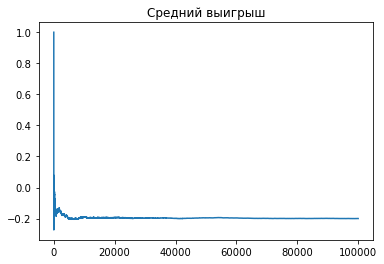

In [4]:
plt.title('Средний выигрыш')
random_average_rewards = average_rewards.copy()
ax = plt.plot(random_average_rewards)

In [5]:
print("Винрейт игрока при случайной стратегии: ", np.where(np.array(player.reward) > 0)[0].shape[0] / n_steps)

Винрейт игрока при случайной стратегии:  0.36444


Дальше с помощью First-Visit Monte Carlo попробуем оценить выигрыш от этой стратегии.

Оптимальная стратегия:  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


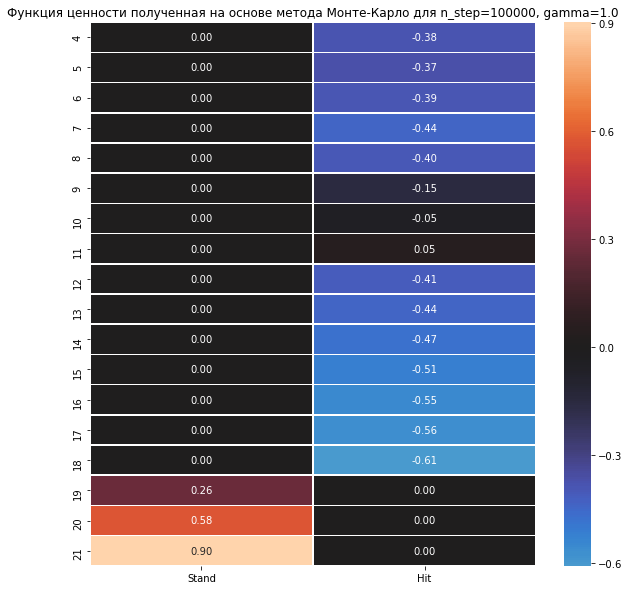

In [6]:
def q_func_pi_func(Q, title):
    Q_list = np.zeros((len(np.arange(4, 22)), 2))

    for i in Q.keys():
        Q_list[i[0] - 4][i[1]] = Q[i]

    f, ax = plt.subplots(figsize=(10, 10))
    plt.title(title)
    ax = sns.heatmap(Q_list, annot=True, fmt=".2f", linewidths=.5, yticklabels=np.arange(4, 22), xticklabels=['Stand', 'Hit'], center=0)    
    pi = list()
    for i in Q_list:
        pi.append(np.argmax(i))

    print("Оптимальная стратегия: ", pi)
    
q_func_pi_func(Q, "Функция ценности полученная на основе метода Монте-Карло для n_step=100000, gamma=1.0")

Получаем оптимальную стратегию, которая говорит нам, что лучше всегда говорить хватит и не добирать карты кроме случая, когда у нас на руках 11 очков, тут мы играем в небольшой плюс:) 

#### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Дальше реализуем класс для Q-обучения. Вот тут я уже задумался, что можно учесть, есть у нас играющий туз или нет и какая карта есть у дилера. Сложно сказать насколько полезна для нас эта информация без подсчета карт. Попробуем сравнить! 
Делаю пока гиперпараметры случайными, например, скорость обучения alpha = 0.1, коэффициент обучения = 0.9, коэффициент для исследования eps = 0.2.

In [7]:
class Q_learning:
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = gym.make('Blackjack-v1')
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action) : 0 for action in (0, 1) for state in (np.arange(4, 22))
        }
        
        self.Q[(21, 0)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()
        
    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = list()
        self.current_state = sum_hand(self.env.player)
        
        while 1:
            game_over, reward = self.next_step(eps)
            if game_over:
                self.player.points.append(sum_hand(self.env.player))
                self.dealer.points.append(sum_hand(self.env.dealer))
                self.player.hands.append(self.env.player)
                self.dealer.hands.append(self.env.dealer)
                self.player.reward.append(reward)
                self.dealer.reward.append(-1 * reward)
                
                self.reward = reward
                for i in reversed(self.state_action_history):
                    reward = self.Q[i] + self.alpha * (reward - self.gamma * self.Q[i])
                    self.Q[i] = reward
                break
                
        
        
    def next_step(self, eps):
        if np.random.random() < eps:
            next_action = np.random.randint(0, 2)
        elif self.Q[(self.current_state, 1)] >= self.Q[(self.current_state, 0)]:
            next_action = 1
        else:
            next_action = 0
        
        self.state_action_history.append((sum_hand(self.env.player), next_action))
        state, reward, game_over_flag, _ = self.env.step(next_action)
        self.current_state = sum_hand(self.env.player)
        
        return (game_over_flag, reward)

In [8]:
results = list()
accum = 0
rewards = list()
average_rewards = list()
    
q_learn = Q_learning(gamma=gamma)

n_steps = 100000

for i in tqdm(range(n_steps)):
    q_learn.sample_round()

    accum += q_learn.reward
    rewards.append(reward)
    average_rewards.append(accum / (i + 1))

results.append(np.where(np.array(q_learn.player.reward) == 1)[0].shape[0] / n_steps)

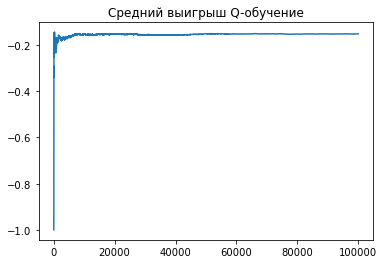

In [9]:
plt.title('Средний выигрыш Q-обучение')
Q_rewards = average_rewards.copy()
ax = plt.plot(Q_rewards)

In [10]:
print("Винрейт игрока при Q-Обучении: ", np.where(np.array(q_learn.player.reward) > 0)[0].shape[0] / n_steps)

Винрейт игрока при Q-Обучении:  0.3861


Оптимальная стратегия:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


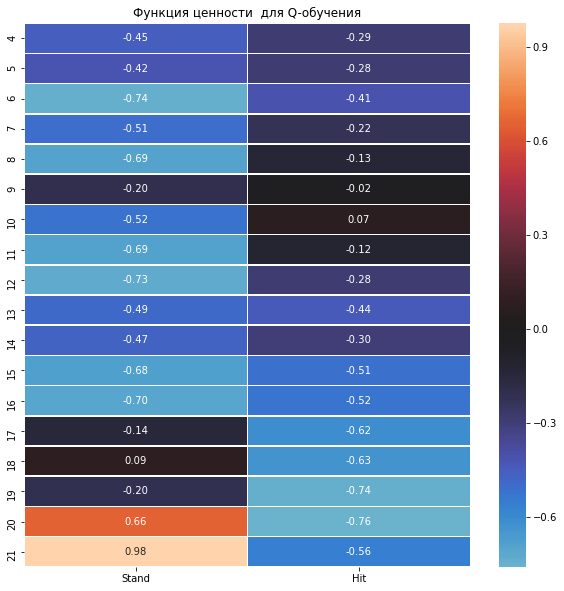

In [11]:
q_func_pi_func(q_learn.Q, "Функция ценности  для Q-обучения")

Теперь оптимальная стратегия почти всегда добирать пока у нас не будет 17 очков.
Попробуем найти функцию ценности с учетом знаний об играющем тузе и открытой карте дилера

In [168]:
class Q_learning_use_ace:
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = gym.make('Blackjack-v1')
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action, use_ace, dealer) : 0 for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1) for state in (np.arange(2, 22))
        }
        
        for i in np.arange(2, 12):
            self.Q[(21, 0, 0, i)] = 1
            self.Q[(21, 0, 1, i)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()
        
    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = list()
        self.current_state = sum_hand(self.env.player)
        
        while 1:
            game_over, reward = self.next_step(eps)
            if game_over:
                self.player.points.append(sum_hand(self.env.player))
                self.dealer.points.append(sum_hand(self.env.dealer))
                self.player.hands.append(self.env.player)
                self.dealer.hands.append(self.env.dealer)
                self.player.reward.append(reward)
                self.dealer.reward.append(-1 * reward)
                
                self.reward = reward
                for i in reversed(self.state_action_history):
                    reward = self.Q[i] + self.alpha * (reward - self.gamma * self.Q[i])
                    self.Q[i] = reward
                    if i[2] == 1:
                        self.Q[(i[0] - 10, i[1], i[2], i[3])] = reward 
                break
                
        
        
    def next_step(self, eps):
        if usable_ace(self.env.player):
            use_ace = 1
        else:
            use_ace = 0
            
        if np.random.random() < eps:
            next_action = np.random.randint(0, 2)
        else:
            hit = self.Q[(self.current_state, 1, use_ace, sum_hand([self.env.dealer[0]]))]
            hit_minus_ace = self.Q[(self.current_state - 10 * use_ace, 1, use_ace, sum_hand([self.env.dealer[0]]))]
            stand = self.Q[(self.current_state, 0, use_ace, sum_hand([self.env.dealer[0]]))]
            stand_minus_ace = self.Q[(self.current_state - 10 * use_ace, 0, use_ace, sum_hand([self.env.dealer[0]]))]
            
            action_dict = {
                0: 1,
                1: 1,
                2: 0,
                3: 0
            }
            
            next_action = action_dict[np.argmax([hit, hit_minus_ace, stand, stand_minus_ace])]

        
        self.state_action_history.append((sum_hand(self.env.player), next_action, use_ace,  sum_hand([self.env.dealer[0]])))
        state, reward, game_over_flag, _ = self.env.step(next_action)
        self.current_state = sum_hand(self.env.player)
        
        return (game_over_flag, reward)    

In [169]:
results = list()
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
    
q_learn = Q_learning_use_ace()

n_steps = 100000

for i in tqdm(range(n_steps)):
    q_learn.sample_round()

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

In [170]:
print("Винрейт игрока при Q Обучении с учетом играющего туза: ", np.where(np.array(q_learn.player.reward) > 0)[0].shape[0] / n_steps)

Винрейт игрока при Q Обучении с учетом играющего туза:  0.39565


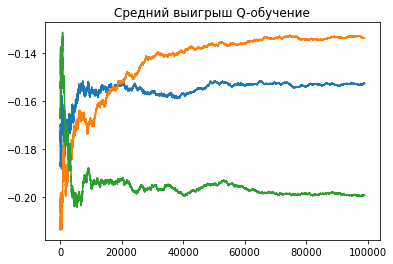

In [171]:
plt.title('Средний выигрыш Q-обучение')
Q_rewards_use_ace = q_learn_average_rewards.copy()
ax = plt.plot(Q_rewards[1000:])
ax = plt.plot(Q_rewards_use_ace[1000:])
ax = plt.plot(random_average_rewards[1000:])

Использование информации об играющем тузе и карте дилера дало улучшение нашей стратегии, средний выигрыш увеличился.

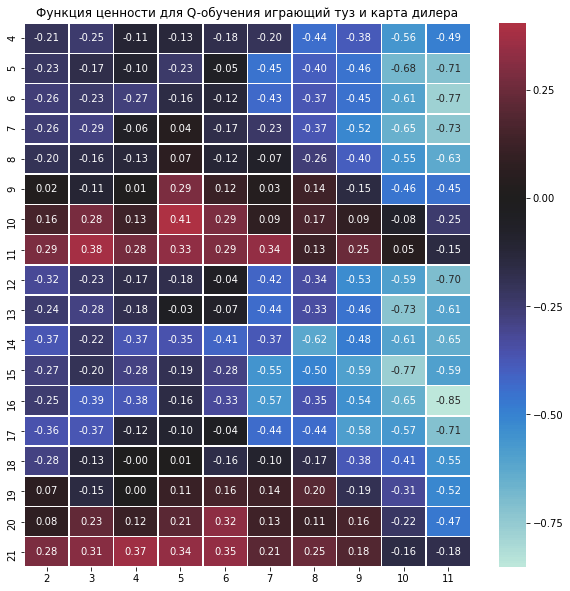

In [172]:
def q_func_pi_func(Q, title):
    Q_list = np.zeros((len(np.arange(4, 22)), len(np.arange(2, 12))))

    for i in Q.keys():
        Q_list[i[0] - 4][i[3] - 2] += Q[i]
    
    Q_list /= 4
    
    f, ax = plt.subplots(figsize=(10, 10))
    plt.title(title)
    ax = sns.heatmap(Q_list, annot=True, fmt=".2f", linewidths=.5, yticklabels=np.arange(4, 22), xticklabels=np.arange(2, 12), center=0)    

    
q_func_pi_func(q_learn.Q, "Функция ценности для Q-обучения играющий туз и карта дилера")

Тут я усреднил функцию ценности по 4 состояниям: есть играющий туз или нет и действие игрока которое он совершает. По видимому стоит сделать вывод, что когда у дилера карманный туз, ловить в раздаче нечего :(

Попробуем теперь получить тоже самое для метода Monte Carlo control. Пока без гиперпараметров, gamma пусть равна 1.0, eps = 0.2

In [182]:
class MC_Control_use_ace(Q_learning_use_ace):   
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = gym.make('Blackjack-v1')
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action, use_ace, dealer) : 0 for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1) for state in (np.arange(2, 22))
        }
        
        self.Q_count = {
            (state, action, use_ace, dealer) : 0 for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1) for state in (np.arange(2, 22))
        }        
        for i in np.arange(2, 12):
            self.Q[(21, 0, 0, i)] = 1
            self.Q[(21, 0, 1, i)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()
    
    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = list()
        self.current_state = sum_hand(self.env.player)
        
        while 1:
            game_over, reward = self.next_step(eps)
            if game_over:
                self.player.points.append(sum_hand(self.env.player))
                self.dealer.points.append(sum_hand(self.env.dealer))
                self.player.hands.append(self.env.player)
                self.dealer.hands.append(self.env.dealer)
                self.player.reward.append(reward)
                self.dealer.reward.append(-1 * reward)
                
                self.reward = reward
                for j in reversed(self.state_action_history):
                    self.Q[j] = (self.Q_count[j] * self.Q[j] + gamma * reward) / (self.Q_count[j] + 1)
                    self.Q_count[j] += 1
                    if j[2] == 1:
                        i = (j[0] - 10, j[1], j[2], j[3])
                        self.Q[i] = (self.Q_count[i] * self.Q[i] + gamma * reward) / (self.Q_count[i] + 1)
                        self.Q_count[i] += 1                        
                break 

In [183]:
accum = 0
mc_control_rewards = list()
mc_control_average_rewards = list()
    
mc_control = MC_Control_use_ace(gamma=1.0)

n_steps = 100000

for i in tqdm(range(n_steps)):
    mc_control.sample_round()

    accum += mc_control.reward
    mc_control_rewards.append(mc_control.reward)
    mc_control_average_rewards.append(accum / (i + 1))

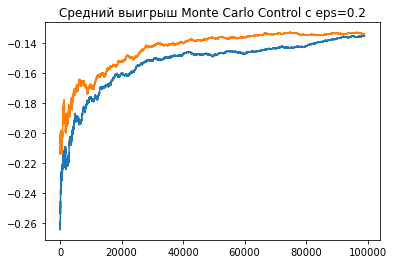

In [184]:
plt.title('Средний выигрыш Monte Carlo Control c eps=0.2')
mc_rewards_use_ace = mc_control_average_rewards.copy()
ax = plt.plot(mc_rewards_use_ace[1000:])
ax = plt.plot(Q_rewards_use_ace[1000:])

In [185]:
print("Винрейт игрока при Monte Carlo Control с учетом играющего туза: ", np.where(np.array(mc_control.player.reward) > 0)[0].shape[0] / n_steps)

Винрейт игрока при Monte Carlo Control с учетом играющего туза:  0.3961


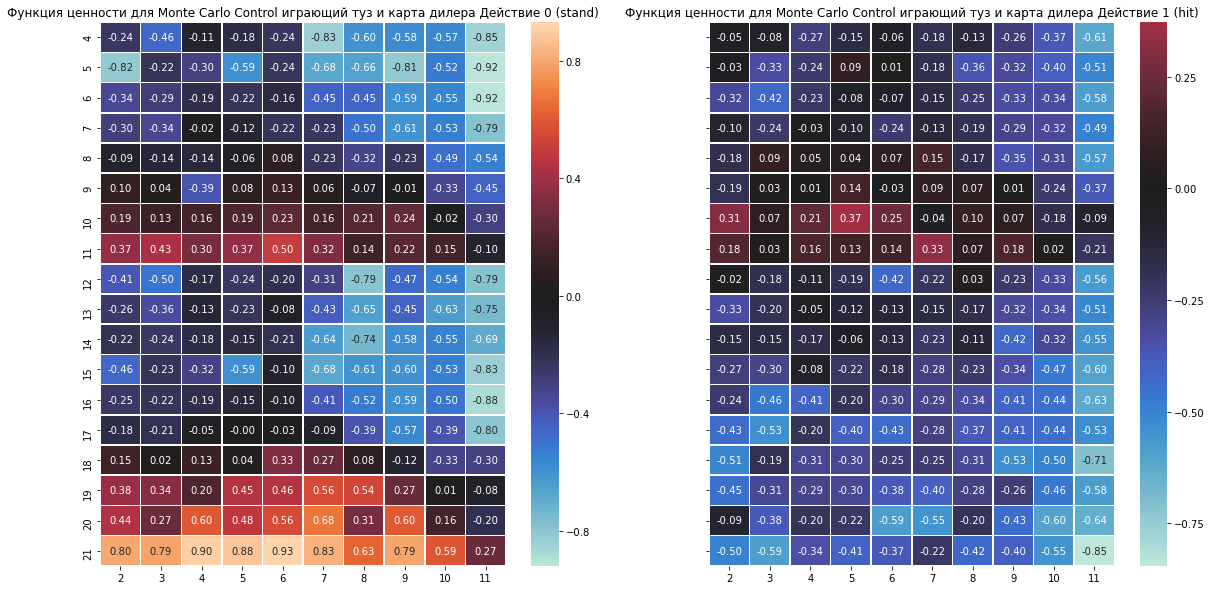

In [186]:
q_func_pi_func(mc_control.Q, "Функция ценности для Monte Carlo Control играющий туз и карта дилера")

По графикам среднего выигрыша Монте-Карло выигрывает у Q-обучения за 100000 эпизодов. Функция ценности выглядит более выраженной.
Попробуем не усреднять функцию по действию и для сравнения построим тепловые карты функций ценности обоих методов рядом.

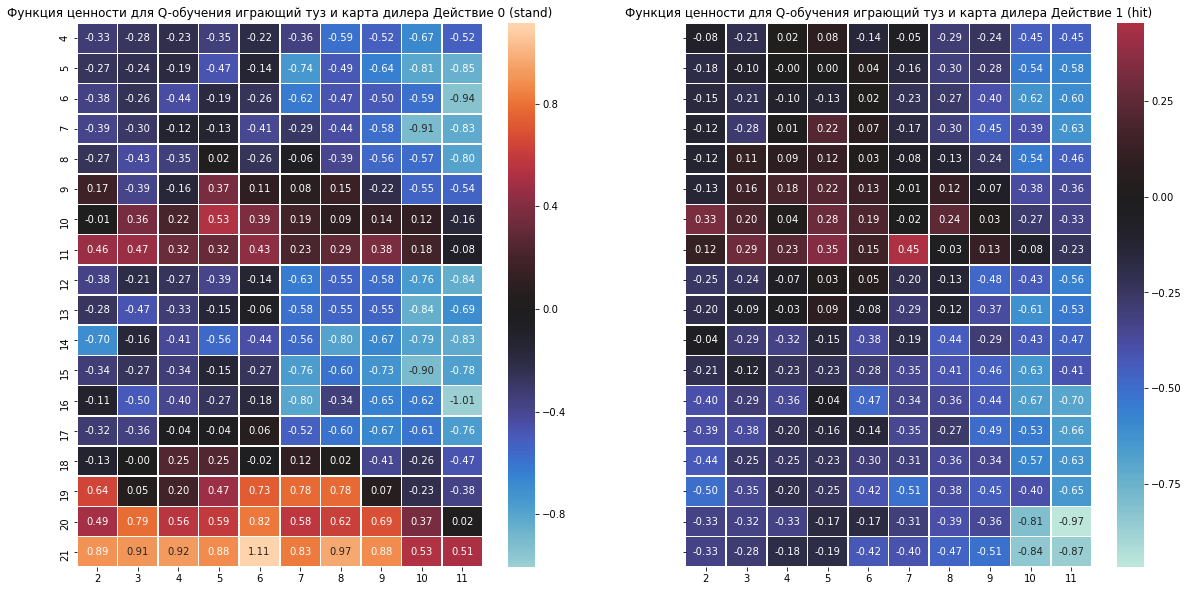

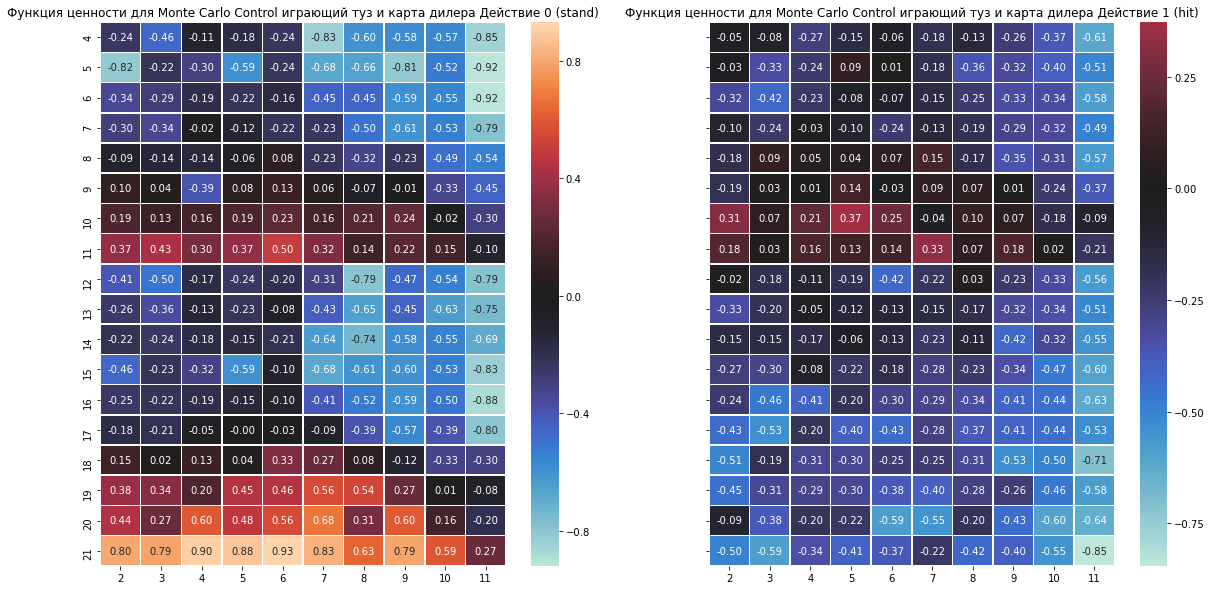

In [187]:
def q_func_pi_func(Q, title):
    Q_list_stand = np.zeros((len(np.arange(4, 22)), len(np.arange(2, 12))))
    Q_list_hit = np.zeros((len(np.arange(4, 22)), len(np.arange(2, 12))))

    for i in Q.keys():
        if i[1] == 0:
            Q_list_stand[i[0] - 4][i[3] - 2] += Q[i]
        else:
            Q_list_hit[i[0] - 4][i[3] - 2] += Q[i]
    
    Q_list_stand /= 2
    Q_list_hit /= 2
    
    f, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
    ax[0].set_title(title + " Действие 0 (stand)")
    ax[0] = sns.heatmap(Q_list_stand, annot=True, fmt=".2f", linewidths=.5, yticklabels=np.arange(4, 22), xticklabels=np.arange(2, 12), center=0, ax=ax[0])    

    ax[1].set_title(title + " Действие 1 (hit)")
    ax[1] = sns.heatmap(Q_list_hit, annot=True, fmt=".2f", linewidths=.5, yticklabels=np.arange(4, 22), xticklabels=np.arange(2, 12), center=0, ax=ax[1])    

q_func_pi_func(q_learn.Q, "Функция ценности для Q-обучения играющий туз и карта дилера")
q_func_pi_func(mc_control.Q, "Функция ценности для Monte Carlo Control играющий туз и карта дилера")

Результаты довольно схожи, видимо нужно большее количество эпизодов, чтобы заметить разницу. Впрочем, и средний выигрыш у них не сильно отличается.

#### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Посмотрим сколько мы проирываем казино за 100 тысяч раздач по 1 доллару каждая:

Выигрыш казино у стратегии Monte Carlo Control за 100к раздач по 1 $: 13510.0
Выигрыш казино у стратегии Q-обучения за 100к раздач по 1 $: 13355.0


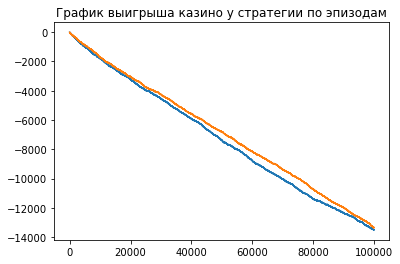

In [188]:
plt.title("График выигрыша казино у стратегии по эпизодам")
ax = plt.plot(np.cumsum(mc_control_rewards))
ax = plt.plot(np.cumsum(q_learn_rewards))
print('Выигрыш казино у стратегии Monte Carlo Control за 100к раздач по 1 $:', -np.sum(mc_control_rewards))
print('Выигрыш казино у стратегии Q-обучения за 100к раздач по 1 $:', -np.sum(q_learn_rewards))

Попробуем подобрать гиперпараметры для выбранных методов. Будем подбирать по винрейту.

In [189]:
results = list()

for gamma in tqdm(np.arange(0.1,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace(gamma=gamma)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(np.where(np.array(q_learn.player.reward) > 0)[0].shape[0] / n_steps)

Лучшая gamma для Q-обучения:  0.95


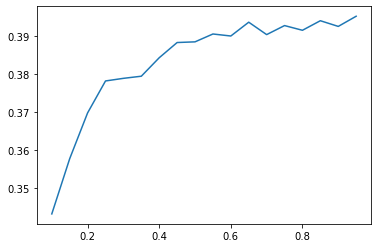

In [190]:
plt.plot(np.arange(0.1,1,0.05), results)
best_gamma = np.arange(0.1,1,0.05)[np.argmax(results)]
print('Лучшая gamma для Q-обучения: ', np.round(best_gamma, 5))

In [191]:
results = list()

for alpha in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace(gamma=best_gamma, alpha=alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(np.where(np.array(q_learn.player.reward) > 0)[0].shape[0] / n_steps)

Лучшая alpha для Q-обучения:  0.05


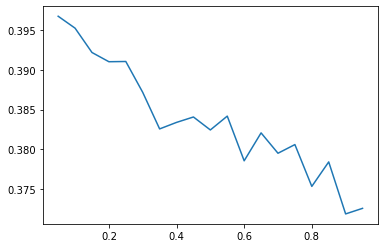

In [193]:
plt.plot(np.arange(0.05,1,0.05), results)
best_alpha = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая alpha для Q-обучения: ', np.round(best_alpha, 5))

In [194]:
results = list()

for eps in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace(gamma=best_gamma, alpha=best_alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round(eps)

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(np.where(np.array(q_learn.player.reward) > 0)[0].shape[0] / n_steps)

Лучшая eps для Q-обучения:  0.05


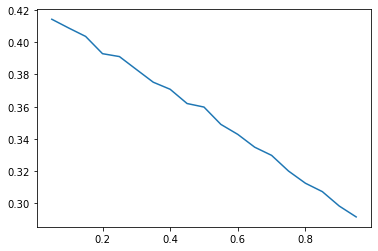

In [195]:
plt.plot(np.arange(0.05,1,0.05), results)
best_eps = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая eps для Q-обучения: ', np.round(best_eps, 5))

Повторим тоже самое для Monte Carlo Control

In [196]:
results = list()

for gamma in tqdm(np.arange(0.1,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    mc_control = MC_Control_use_ace(gamma=gamma)

    n_steps = 100000

    for i in range(n_steps):
        mc_control.sample_round()

        accum += mc_control.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(np.where(np.array(mc_control.player.reward) > 0)[0].shape[0] / n_steps)

Лучшая gamma для Monte Carlo Control:  0.7


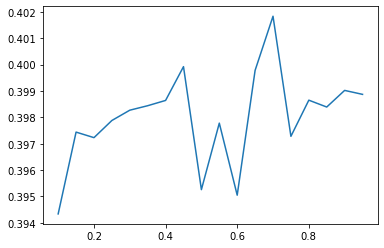

In [197]:
plt.plot(np.arange(0.1,1,0.05), results)
best_mc_gamma = np.arange(0.1,1,0.05)[np.argmax(results)]
print('Лучшая gamma для Monte Carlo Control: ', np.round(best_mc_gamma, 5))

In [199]:
results = list()

for eps in tqdm(np.arange(0.01,0.96,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    mc_control = MC_Control_use_ace(gamma=best_mc_gamma)

    n_steps = 100000

    for i in range(n_steps):
        mc_control.sample_round(eps)

        accum += mc_control.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(np.where(np.array(mc_control.player.reward) > 0)[0].shape[0] / n_steps)

Лучшая eps для Monte Carlo Control:  0.01


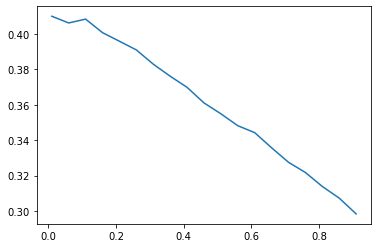

In [201]:
plt.plot(np.arange(0.01,0.96,0.05), results)
best_mc_eps = np.arange(0.01,0.96,0.05)[np.argmax(results)]
print('Лучшая eps для Monte Carlo Control: ', np.round(best_mc_eps, 5))

Попробуем сравнить средний выигрыш по Q-обучению и по Monte Carlo Control с учетом полученных значений гиперпараметров

In [203]:
accum = 0
mc_control_rewards = list()
mc_control_average_rewards = list()
best_mc_gamma = 0.7
best_mc_eps = 0.01
    
mc_control = MC_Control_use_ace(gamma=best_mc_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    mc_control.sample_round(best_mc_eps)

    accum += mc_control.reward
    mc_control_rewards.append(mc_control.reward)
    mc_control_average_rewards.append(accum / (i + 1))

In [204]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.05
best_gamma = 0.95
best_eps = 0.05

q_learn = Q_learning_use_ace(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

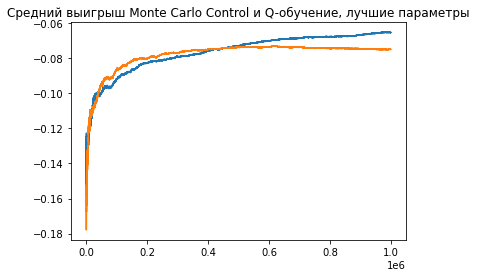

In [205]:
plt.title('Средний выигрыш Monte Carlo Control и Q-обучение, лучшие параметры')
ax = plt.plot(mc_control_average_rewards[1000:])
ax = plt.plot(q_learn_average_rewards[1000:])

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


#### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

Реализуем новый вариант окружения. Колода стандартная бесконечная, изменения только в методе step, где добавляем ветку для действия double

In [577]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(3))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action, double):
        assert self.action_space.contains(action)
        if not double:
            if action:  # hit: add a card to players hand and return
                self.player.append(draw_card(self.np_random))
                if is_bust(self.player):
                    done = True
                    reward = -1.0
                else:
                    done = False
                    reward = 0.0
            else:  # stick: play out the dealers hand, and score
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1.0:
                    reward = 1.5       
        else:
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -2.0
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
                
            if double:
                reward *= 2
       
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()


In [578]:
class Q_learning_use_ace_double(Q_learning_use_ace):
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = BlackjackEnv()
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action, use_ace, dealer) : 0 for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1, 2) for state in (np.arange(2, 22))
        }
        
        for i in np.arange(2, 12):
            self.Q[(21, 0, 0, i)] = 1
            self.Q[(21, 0, 1, i)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()
        
        
    def next_step(self, eps):
        if usable_ace(self.env.player):
            use_ace = 1
        else:
            use_ace = 0
            
        if np.random.random() < eps:
            next_action = np.random.randint(0, 2)
            if next_action == 1:
                double = np.random.randint(0, 2)
            else:
                double = 0    
                
        else:
            hit = self.Q[(self.current_state, 1, use_ace, sum_hand([self.env.dealer[0]]))]
            hit_minus_ace = self.Q[(self.current_state - 10 * use_ace, 1, use_ace, sum_hand([self.env.dealer[0]]))]
            stand = self.Q[(self.current_state, 0, use_ace, sum_hand([self.env.dealer[0]]))]
            stand_minus_ace = self.Q[(self.current_state - 10 * use_ace, 0, use_ace, sum_hand([self.env.dealer[0]]))]
            double = self.Q[(self.current_state, 2, use_ace, sum_hand([self.env.dealer[0]]))]
            double_minus_ace = self.Q[(self.current_state - 10 * use_ace, 2, use_ace, sum_hand([self.env.dealer[0]]))]
                        
            
            action_dict = {
                0: 1,
                1: 1,
                2: 0,
                3: 0,
                4: 1,
                5: 1
            }   
            
            next_action = action_dict[np.argmax([hit, hit_minus_ace, stand, stand_minus_ace, double, double_minus_ace])]
            
            if action_dict[np.argmax([hit, hit_minus_ace, stand, stand_minus_ace, double, double_minus_ace])] > 3:
                double = 1
            else:
                double = 0      
            
        
        self.state_action_history.append((sum_hand(self.env.player), next_action + double, use_ace,  sum_hand([self.env.dealer[0]])))
        state, reward, game_over_flag, _ = self.env.step(next_action, double)
        self.current_state = sum_hand(self.env.player)
        
        return (game_over_flag, reward)    

In [579]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.05
best_gamma = 0.95
best_eps = 0.05

q_learn = Q_learning_use_ace_double(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

Попробуем посчитать теперь оптимальную стратегию для агента для полученно Q функции

In [580]:
def pi_func(Q):
    Q_list_stand = np.zeros((len(np.arange(2, 22)), len(np.arange(2, 12))))
    Q_list_hit = np.zeros((len(np.arange(2, 22)), len(np.arange(2, 12))))
    Q_list_double = np.zeros((len(np.arange(2, 22)), len(np.arange(2, 12))))

    Q_list_stand_use = np.zeros((len(np.arange(2, 22)), len(np.arange(2, 12))))
    Q_list_hit_use = np.zeros((len(np.arange(2, 22)), len(np.arange(2, 12))))
    Q_list_double_use = np.zeros((len(np.arange(2, 22)), len(np.arange(2, 12))))    
    
    for i in Q.keys():
        if i[1] == 0 and i[2] == 1:
            Q_list_stand_use[i[0] - 4][i[3] - 2] = Q[i]
        if i[1] == 0 and i[2] == 0:
            Q_list_stand[i[0] - 4][i[3] - 2] = Q[i]            
        if i[1] == 1 and i[2] == 1:
            Q_list_hit_use[i[0] - 4][i[3] - 2] = Q[i]
        if i[1] == 1 and i[2] == 0:
            Q_list_hit[i[0] - 4][i[3] - 2] = Q[i]   
        if i[1] == 2 and i[2] == 1:
            Q_list_double_use[i[0] - 4][i[3] - 2] = Q[i]
        if i[1] == 2 and i[2] == 0:
            Q_list_double[i[0] - 4][i[3] - 2] = Q[i]               
    
    pi = np.zeros_like(Q_list_stand)
    pi_use = np.zeros_like(Q_list_stand)
    
    for i in range(Q_list_stand.shape[0]):
        for j in range(Q_list_stand.shape[1]):
            pi[i][j] = np.argmax([Q_list_stand[i][j], Q_list_hit[i][j], Q_list_double[i][j]])
            pi_use[i][j] = np.argmax([Q_list_stand_use[i][j], Q_list_hit_use[i][j], Q_list_double_use[i][j]])
        
    
    f, ax = plt.subplots(1, 2, figsize=(15, 15), sharey=True)
    ax[0].set_title("Стратегия Pi нет играющего туза")
    ax[0] = sns.heatmap(pi, annot=True, fmt=".2f", linewidths=.5, yticklabels=np.arange(2, 22), xticklabels=np.arange(2, 12), center=0, ax=ax[0])    
    ax[1].set_title("Стратегия Pi есть играющий туз")
    ax[1] = sns.heatmap(pi_use, annot=True, fmt=".2f", linewidths=.5, yticklabels=np.arange(2, 22), xticklabels=np.arange(2, 12), center=0, ax=ax[1])    

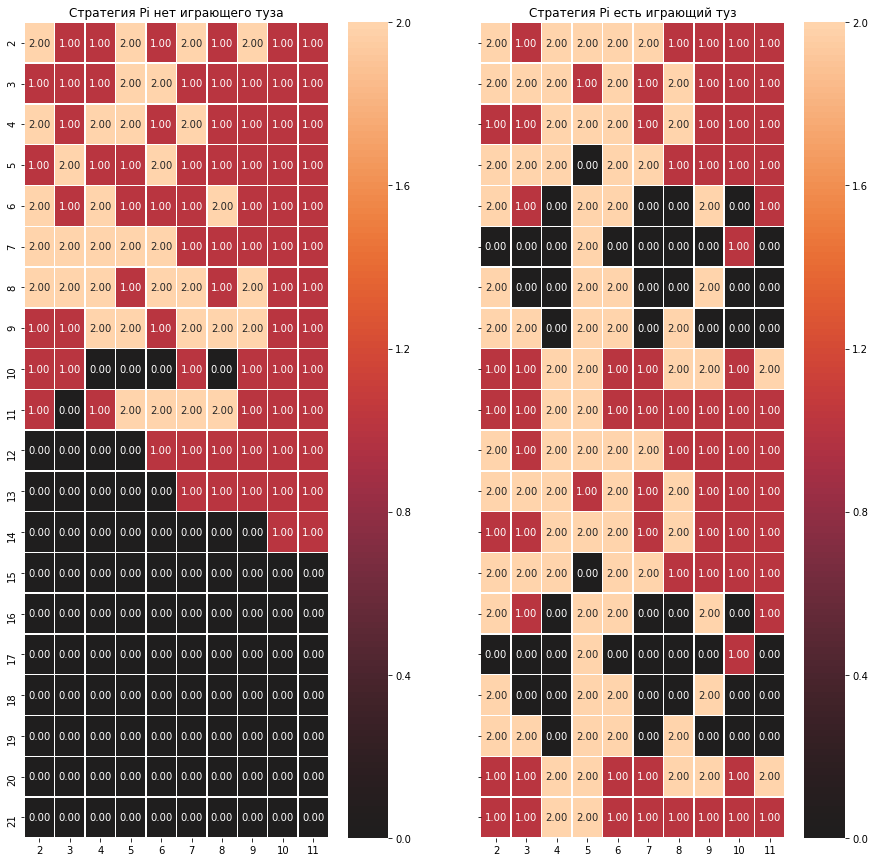

In [581]:
pi_func(q_learn.Q)

Была еще одна интересная идея для стратегии удвоения. Заключалась в следующем: во время обновления функции Q, добавлять в состояния с удвоением награду x2 даже если агент решил так не делать в предыдущем эпизоде. Таким образом, мы проталкиваем информацию агенту, что он мог бы лучше сделать в этом состоянии - вместо обычной ставки сделать удвоенную, или если он проиграл, то указать ему, что с удвоенной ставкой он проиграл бы еще больше

In [582]:
class Q_learning_use_ace_double_update(Q_learning_use_ace_double):
    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = list()
        self.current_state = sum_hand(self.env.player)
        
        while 1:
            game_over, reward = self.next_step(eps)
            if game_over:
                self.player.points.append(sum_hand(self.env.player))
                self.dealer.points.append(sum_hand(self.env.dealer))
                self.player.hands.append(self.env.player)
                self.dealer.hands.append(self.env.dealer)
                self.player.reward.append(reward)
                self.dealer.reward.append(-1 * reward)
                
                self.reward = reward
                double_reward_update_flag = True
                for i in reversed(self.state_action_history):
                    reward = self.Q[i] + self.alpha * (reward - self.gamma * self.Q[i])
                    self.Q[i] = reward
                    if i[2] == 1:
                        self.Q[(i[0] - 10, i[1], i[2], i[3])] = reward 
                    if double_reward_update_flag and i[1] == 1:
                        self.Q[(i[0], 2, i[2], i[3])] = reward * 2
                        if i[2] == 1:
                            self.Q[(i[0] - 10, 2, i[2], i[3])] = reward * 2
                        double_reward_update_flag = False    
                    
                break

In [583]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.05
best_gamma = 0.95

eps = 0.9
best_eps = 0.05

q_learn = Q_learning_use_ace_double_update(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

Карта оптимальной стратегии получилась довольно странной - в основном всегда необходимо говорить хватит

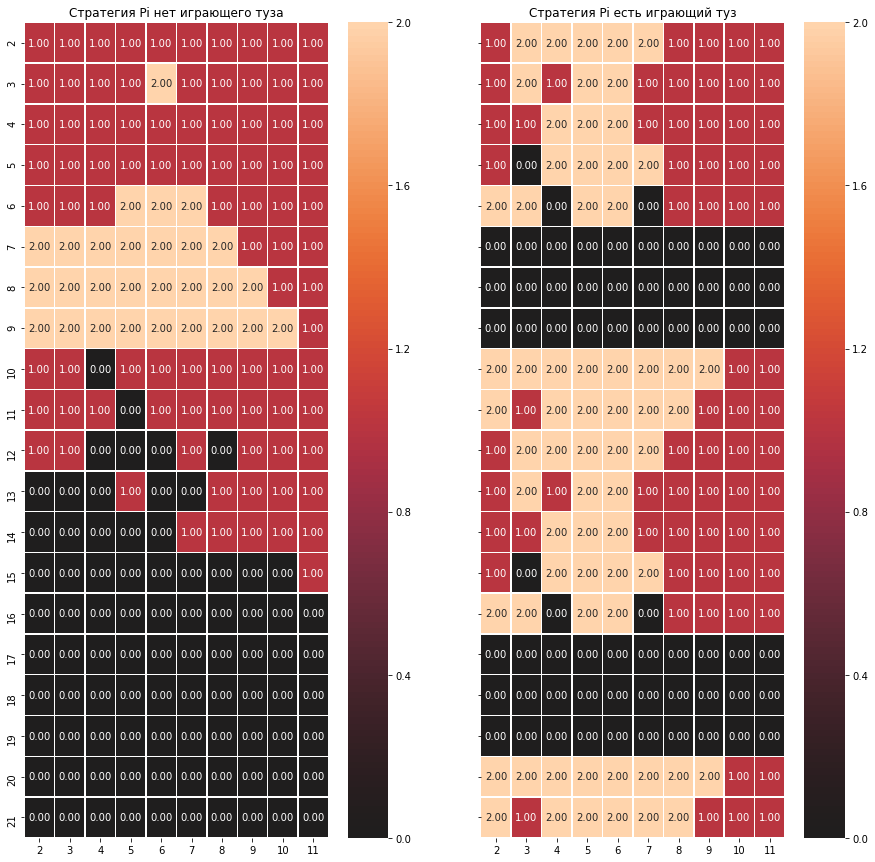

In [584]:
pi_func(q_learn.Q)

In [585]:
class MC_Control_use_ace_double(Q_learning_use_ace_double):   
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = BlackjackEnv()
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action, use_ace, dealer) : 0 for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1, 2) for state in (np.arange(2, 22))
        }
        
        self.Q_count = {
            (state, action, use_ace, dealer) : 0 for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1, 2) for state in (np.arange(2, 22))
        }        
        for i in np.arange(2, 12):
            self.Q[(21, 0, 0, i)] = 1
            self.Q[(21, 0, 1, i)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()
    
    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = list()
        self.current_state = sum_hand(self.env.player)
        
        while 1:
            game_over, reward = self.next_step(eps)
            if game_over:
                self.player.points.append(sum_hand(self.env.player))
                self.dealer.points.append(sum_hand(self.env.dealer))
                self.player.hands.append(self.env.player)
                self.dealer.hands.append(self.env.dealer)
                self.player.reward.append(reward)
                self.dealer.reward.append(-1 * reward)
                
                self.reward = reward
                for j in reversed(self.state_action_history):
                    self.Q[j] = (self.Q_count[j] * self.Q[j] + gamma * reward) / (self.Q_count[j] + 1)
                    self.Q_count[j] += 1
                    if j[2] == 1:
                        i = (j[0] - 10, j[1], j[2], j[3])
                        self.Q[i] = (self.Q_count[i] * self.Q[i] + gamma * reward) / (self.Q_count[i] + 1)
                        self.Q_count[i] += 1                        
                break 

In [586]:
accum = 0
mc_control_rewards = list()
mc_control_average_rewards = list()
best_mc_gamma = 0.7
best_mc_eps = 0.01
    
mc_control = MC_Control_use_ace_double(gamma=best_mc_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    mc_control.sample_round(best_mc_eps)

    accum += mc_control.reward
    mc_control_rewards.append(mc_control.reward)
    mc_control_average_rewards.append(accum / (i + 1))

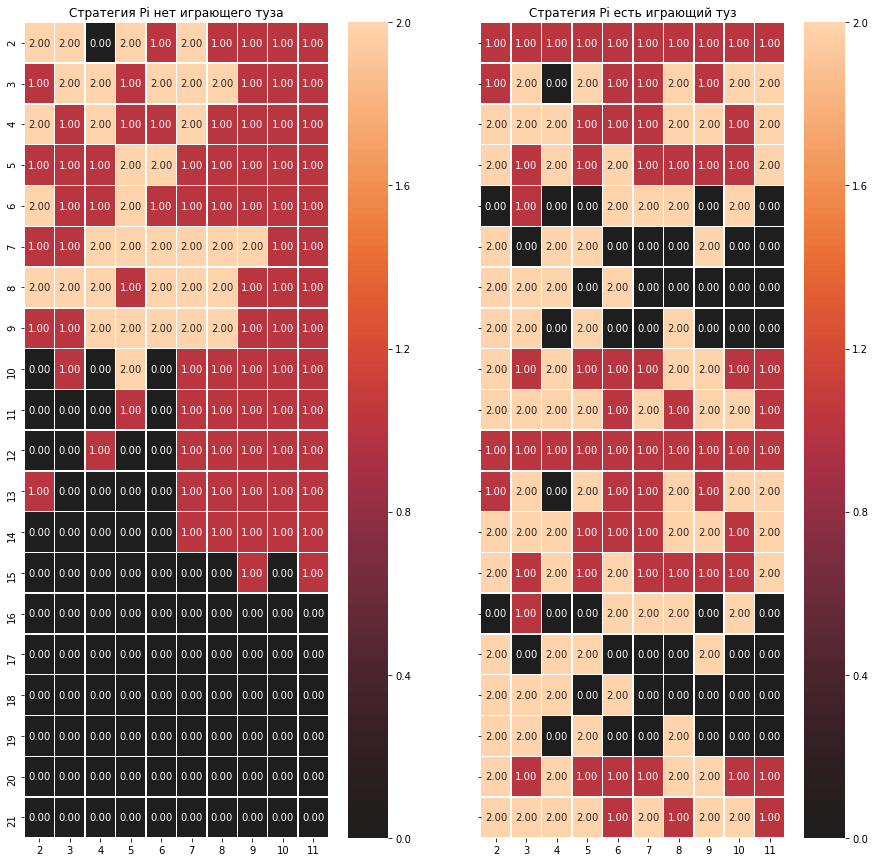

In [587]:
pi_func(mc_control.Q)

In [588]:
print("Винрейт игрока при Monte Carlo Control с удвоением: ", np.where(np.array(mc_control.player.reward) > 0)[0].shape[0] / n_steps)

Винрейт игрока при Monte Carlo Control с удвоением:  0.410896


In [589]:
results = list()

for gamma in tqdm(np.arange(0.1,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double(gamma=gamma)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая gamma для Q-обучения:  0.6


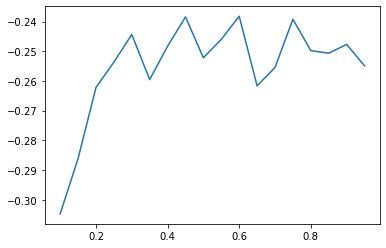

In [590]:
plt.plot(np.arange(0.1,1,0.05), results)
best_gamma = np.arange(0.1,1,0.05)[np.argmax(results)]
print('Лучшая gamma для Q-обучения: ', np.round(best_gamma, 5))

In [591]:
results = list()

for alpha in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double(gamma=best_gamma, alpha=alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая alpha для Q-обучения:  0.1


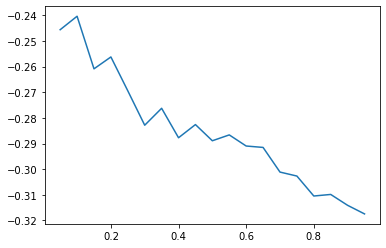

In [592]:
plt.plot(np.arange(0.05,1,0.05), results)
best_alpha = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая alpha для Q-обучения: ', np.round(best_alpha, 5))

In [593]:
results = list()

for eps in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double(gamma=best_gamma, alpha=best_alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round(eps)

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая eps для Q-обучения:  0.05


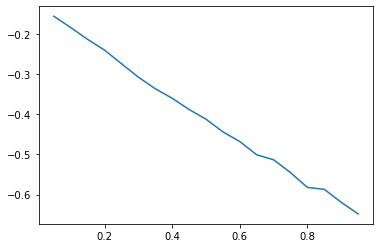

In [594]:
plt.plot(np.arange(0.05,1,0.05), results)
best_eps = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая eps для Q-обучения: ', np.round(best_eps, 5))

In [595]:
results = list()

for gamma in tqdm(np.arange(0.1,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    mc_control = MC_Control_use_ace_double(gamma=gamma)

    n_steps = 100000

    for i in range(n_steps):
        mc_control.sample_round()

        accum += mc_control.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая gamma для Monte Carlo Control:  0.6


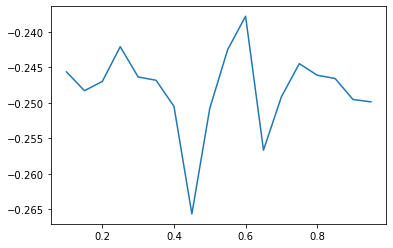

In [596]:
plt.plot(np.arange(0.1,1,0.05), results)
best_mc_gamma = np.arange(0.1,1,0.05)[np.argmax(results)]
print('Лучшая gamma для Monte Carlo Control: ', np.round(best_mc_gamma, 5))

In [597]:
results = list()

for eps in tqdm(np.arange(0.01,0.96,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    mc_control = MC_Control_use_ace_double(gamma=best_mc_gamma)

    n_steps = 100000

    for i in range(n_steps):
        mc_control.sample_round(eps)

        accum += mc_control.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая eps для Monte Carlo Control:  0.06


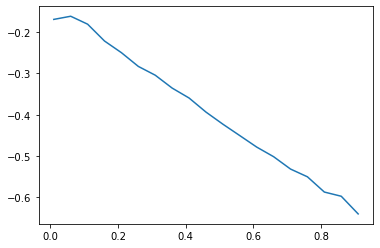

In [598]:
plt.plot(np.arange(0.01,0.96,0.05), results)
best_mc_eps = np.arange(0.01,0.96,0.05)[np.argmax(results)]
print('Лучшая eps для Monte Carlo Control: ', np.round(best_mc_eps, 5))

In [601]:
accum = 0
mc_control_rewards = list()
mc_control_average_rewards = list()
best_mc_gamma = 0.6
best_mc_eps = 0.06
    
mc_control = MC_Control_use_ace_double(gamma=best_mc_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    mc_control.sample_round(best_mc_eps)

    accum += mc_control.reward
    mc_control_rewards.append(mc_control.reward)
    mc_control_average_rewards.append(accum / (i + 1))

In [602]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.1
best_gamma = 0.6
best_eps = 0.05

q_learn = Q_learning_use_ace_double(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

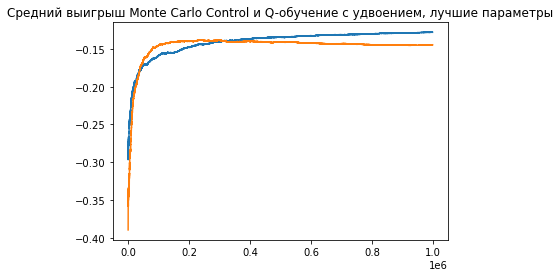

In [603]:
plt.title('Средний выигрыш Monte Carlo Control и Q-обучение с удвоением, лучшие параметры')
ax = plt.plot(mc_control_average_rewards[1000:])
ax = plt.plot(q_learn_average_rewards[1000:])

Попробуем вариат Q-обучения c дополнительным проталкиванием информации в состояния с обновлением, даже если агент его не выбрал

In [606]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.15
best_gamma = 0.9
best_eps = 0.15

q_learn = Q_learning_use_ace_double_update(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

Так получается, лучше, чем без обновления, но в итоге средний выигрыш стал для обоих моделей хуже, чем в варианте без удвоения

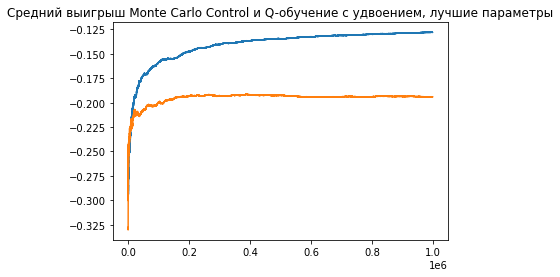

In [607]:
plt.title('Средний выигрыш Monte Carlo Control и Q-обучение с удвоением, лучшие параметры')
ax = plt.plot(mc_control_average_rewards[1000:])
ax = plt.plot(q_learn_average_rewards[1000:])

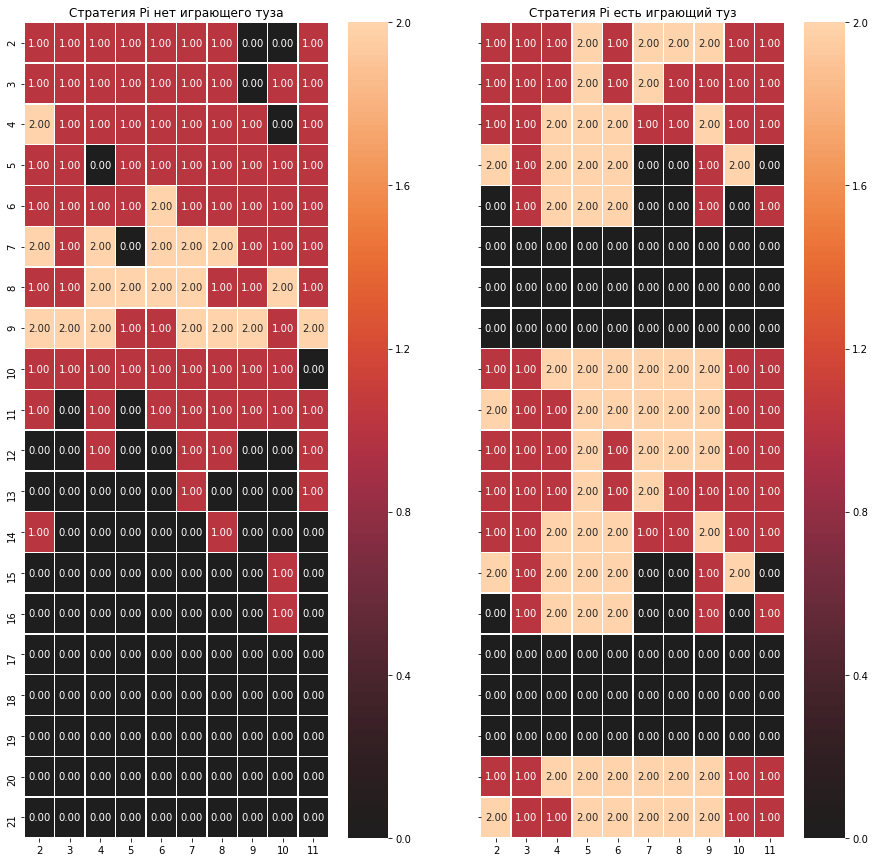

In [608]:
pi_func(q_learn.Q)

Как вариант можно еще попробовать динамически уменьшать исследовательский коэффициент и это дает дополнительный прирост к значению средней награды

In [610]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.1
best_gamma = 0.6

best_eps = 0.15
last_eps = 0.01

delta_eps = best_eps - last_eps

q_learn = Q_learning_use_ace_double_update(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)
    
    if (i + 1) % 100000 == 0:
        best_eps -= delta_eps / 10

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

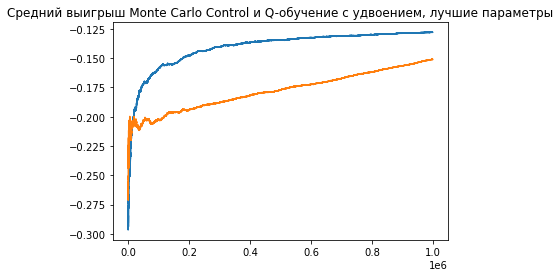

In [611]:
plt.title('Средний выигрыш Monte Carlo Control и Q-обучение с удвоением, лучшие параметры')
ax = plt.plot(mc_control_average_rewards[1000:])
ax = plt.plot(q_learn_average_rewards[1000:])

Тем не менее, в чистом виде без дополнительных возможностей, удвоение больше играет в минус, чем в плюс

## Часть третья, в главной роли — Дастин Хоффман


А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Перепишем среду для того, чтобы колода не была бесконечной, иначе считать карты кажется бесконечно затеей. Будем перемешивать колоду когда карты заканчиваются. Дополнительно сразу можно реализовать подсчет карт по схеме: для 2,3,4,5,6 +1, для 7,8,9 0, во всех остальных случаях -1 

Во время обучения будем принимать три действия для подсчета: 0, когда у нас отрицательная сумма в эпизоде, 1, когда сумма не превышает 5 и, если больше, то 2. Это чисто эмпирические числа, я решил так квантовать, чтобы не раздувать количество состояний. Кроме этого, решил, что если с положительными суммами не так ясно, то с отрицательными точно есть смысл обучать агента тому, что любая отрицательная сумма это невыгодно, хотя...

Кроме этого я сразу реализовал в окружении бонусный сплит (функция def resplit()), но для чистоты эксперимента сначала попробуем обучить агента без него

In [612]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from copy import deepcopy

class BlackjackPlayer:
    def __init__(self):
        self.points = list()
        self.hands = list()
        self.reward = list()
        
    def clear(self):
        self.points = list()
        self.hands = list() 
        self.reward = list()

def cmp(a, b):
    return float(a > b) - float(a < b)


class Deck:
    def __init__(self): 
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

        self.card_score = 0        

    def shuffle_cards(self):
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

        self.card_score = 0

    def calc_cards(self, current):
        if current in {2, 3, 4, 5, 6}:
            self.card_score += 1
        elif current in {7, 8, 9}:
            self.card_score += 0
        else:
            self.card_score -= 1

    def draw_card(self, np_random):
        try:
            next_card = int(np_random.choice(self.deck))
        except Exception:
            self.shuffle_cards()
            next_card = int(np_random.choice(self.deck))
        self.calc_cards(next_card)
        self.deck.remove(next_card)

        return next_card


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(3))
        )
        self.seed()
        self.deck = Deck()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()
        

        
    
    def give_current_score(self):
        return self.deck.card_score    

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def check_hand(self, hand):
        if is_bust(hand):
            done = True
            reward = -1.0
        else:
            done = False
            reward = 0.0
            
        return done, reward
            
    def resplit(self, split, state_action_history):
        resplit_player = list()
        resplit_state_action_history = list()
        done = list()
        reward = list()
        splited = list()
        for i in range(len(split)):
            if split[i] == 1 and len(self.player[i]) == 2 and self.player[i][0] == self.player[i][1]:
                splited.append(True)
                tmp = [self.player[i][0], self.deck.draw_card(self.np_random)]
                resplit_player.append(tmp)
                d_, r_ = self.check_hand(tmp)
                done.append(d_)
                reward.append(r_)
                resplit_state_action_history.append(list())
                
                splited.append(True)
                tmp = [self.player[i][1], self.deck.draw_card(self.np_random)]
                resplit_player.append(tmp)
                d_, r_ = self.check_hand(tmp)
                done.append(d_)
                reward.append(r_)                
                resplit_state_action_history.append(list())
            else:
                splited.append(False)
                resplit_player.append(self.player[i])
                d_, r_ = self.check_hand(self.player[i])
                done.append(d_)
                reward.append(r_)
                resplit_state_action_history.append(state_action_history[i])
                
        self.player = resplit_player.copy()

        return splited, reward, done, resplit_state_action_history
                
                

    def step(self, action, double):
        #assert self.action_space.contains(action)
        done = list()
        reward = list()
        
        for i in range(len(self.player)):
            reward.append(0.0)
            if not double[i]:
                if action[i]:  # hit: add a card to players hand and return
                    self.player[i].append(self.deck.draw_card(self.np_random))
                    if is_bust(self.player[i]):
                        done.append(True)
                        reward[i] = -1.0
                    else:
                        done.append(False)
                        reward[i] = 0.0
                else:  # stick: play out the dealers hand, and score
                    done.append(True)

                    if self.natural and is_natural(self.player) and reward == 1.0:
                        reward[i] = 1.5
                    else:
                        reward[i] = 0.0
            else:
                self.player[i].append(self.deck.draw_card(self.np_random))
                if is_bust(self.player[i]):
                    done.append(True)
                    reward[i] = -2.0
                else:
                    done.append(True)


        done_check = True
        for i in done:
            done_check = done_check and i
            
        if done_check:
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.deck.draw_card(self.np_random))
                
            for i in range(len(self.player)):
                reward[i] = cmp(score(self.player[i]), score(self.dealer)) 
            if double[i]:
                reward[i] *= 2
          
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (len(self.player), self.dealer[0], usable_ace(self.player))
            

    def reset(self):
        if len(self.deck.deck) < 15:
            self.deck.shuffle_cards()
            
        self.dealer = self.deck.draw_hand(self.np_random)
        self.player = [self.deck.draw_hand(self.np_random)]
        return self._get_obs()

#### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Реализуем обучение с подсчетом карт для Q-learning и для Monte Carlo Control

In [613]:
class Q_learning_use_ace_double_update_calc(Q_learning_use_ace_double):
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = BlackjackEnv()
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action, use_ace, dealer, heat) : 0 for heat in (0,1,2) for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1, 2) for state in (np.arange(2, 22))
        }
        
        for i in np.arange(2, 12):
            for j in (0, 1, 2):
                self.Q[(21, 0, 0, i, j)] = 1
                self.Q[(21, 0, 1, i, j)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()
        
        
    def next_step(self, eps):
        if usable_ace(self.env.player[0]):
            use_ace = 1
        else:
            use_ace = 0

        if self.env.give_current_score() <= 0:
            heat = 0
        elif self.env.give_current_score() < 5:
            heat = 1
        else:
            heat = 2
            
        if np.random.random() < eps:
            next_action = np.random.randint(0, 2)
            if next_action == 1:
                double = np.random.randint(0, 2)
            else:
                double = 0    
                
        else:
            hit = self.Q[(self.current_state, 1, use_ace, sum_hand([self.env.dealer[0]]), heat)]
            hit_minus_ace = self.Q[(self.current_state - 10 * use_ace, 1, use_ace, sum_hand([self.env.dealer[0]]), heat)]
            stand = self.Q[(self.current_state, 0, use_ace, sum_hand([self.env.dealer[0]]), heat)]
            stand_minus_ace = self.Q[(self.current_state - 10 * use_ace, 0, use_ace, sum_hand([self.env.dealer[0]]), heat)]
            double = self.Q[(self.current_state, 2, use_ace, sum_hand([self.env.dealer[0]]), heat)]
            double_minus_ace = self.Q[(self.current_state - 10 * use_ace, 2, use_ace, sum_hand([self.env.dealer[0]]), heat)]
                        
            
            action_dict = {
                0: 1,
                1: 1,
                2: 0,
                3: 0,
                4: 1,
                5: 1
            }   
            
            next_action = action_dict[np.argmax([hit, hit_minus_ace, stand, stand_minus_ace, double, double_minus_ace])]
            
            if action_dict[np.argmax([hit, hit_minus_ace, stand, stand_minus_ace, double, double_minus_ace])] > 3:
                double = 1
            else:
                double = 0      
            
        
        self.state_action_history.append((sum_hand(self.env.player[0]), next_action + double, use_ace,  sum_hand([self.env.dealer[0]]), heat))
        state, reward, game_over_flag, _ = self.env.step([next_action], [double])
        self.current_state = sum_hand(self.env.player[0])
        
        return (game_over_flag, reward)    

    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = list()
        self.current_state = sum_hand(self.env.player[0])
        
        while 1:
            game_over, reward = self.next_step(eps)
            if game_over:
                self.player.points.append(sum_hand(self.env.player[0]))
                self.dealer.points.append(sum_hand(self.env.dealer))
                self.player.hands.append(self.env.player[0])
                self.dealer.hands.append(self.env.dealer)
                self.player.reward.append(reward[0])
                self.dealer.reward.append(-1 * reward[0])
                
                reward = reward[0]
                self.reward = reward
                for i in reversed(self.state_action_history):
                    reward = self.Q[i] + self.alpha * (reward - self.gamma * self.Q[i])
                    self.Q[i] = reward
                    if i[2] == 1:
                        self.Q[(i[0] - 10, i[1], i[2], i[3], i[4])] = reward   
                    
                break    
    

In [614]:
class MC_Control_use_ace_double_calc(Q_learning_use_ace_double_update_calc):   
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = BlackjackEnv()
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action, use_ace, dealer, heat) : 0 for heat in (0,1,2) for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1, 2) for state in (np.arange(2, 22))
        }
        
        self.Q_count = {
            (state, action, use_ace, dealer, heat) : 0 for heat in (0,1,2) for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1, 2) for state in (np.arange(2, 22))
        }
        
        for i in np.arange(2, 12):
            for j in (0, 1, 2):
                self.Q[(21, 0, 0, i, j)] = 1
                self.Q[(21, 0, 1, i, j)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()
    
    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = list()
        self.current_state = sum_hand(self.env.player[0])
        
        while 1:
            game_over, reward = self.next_step(eps)
            if game_over:
                self.player.points.append(sum_hand(self.env.player[0]))
                self.dealer.points.append(sum_hand(self.env.dealer))
                self.player.hands.append(self.env.player[0])
                self.dealer.hands.append(self.env.dealer)
                self.player.reward.append(reward)
                self.dealer.reward.append(-1 * reward)
                
                reward = reward[0]
                self.reward = reward
                for j in reversed(self.state_action_history):
                    self.Q[j] = (self.Q_count[j] * self.Q[j] + gamma * reward) / (self.Q_count[j] + 1)
                    self.Q_count[j] += 1
                    if j[2] == 1:
                        i = (j[0] - 10, j[1], j[2], j[3], j[4])
                        self.Q[i] = (self.Q_count[i] * self.Q[i] + gamma * reward) / (self.Q_count[i] + 1)
                        self.Q_count[i] += 1                        
                break 

Снова попробуем подобрать гиперпараметры для моделей

In [615]:
results = list()

for gamma in tqdm(np.arange(0.1,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    mc_control = MC_Control_use_ace_double_calc(gamma=gamma)

    n_steps = 100000

    for i in range(n_steps):
        mc_control.sample_round()

        accum += mc_control.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая gamma для Monte Carlo Control:  0.65


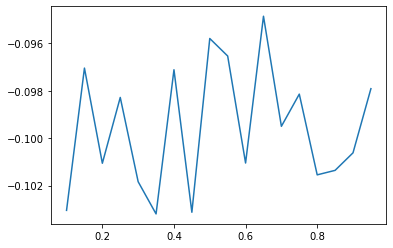

In [616]:
plt.plot(np.arange(0.1,1,0.05), results)
best_mc_gamma = np.arange(0.1,1,0.05)[np.argmax(results)]
print('Лучшая gamma для Monte Carlo Control: ', np.round(best_mc_gamma, 5))

In [617]:
results = list()

for eps in tqdm(np.arange(0.01,0.96,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    mc_control = MC_Control_use_ace_double_calc(gamma=best_mc_gamma)

    n_steps = 100000

    for i in range(n_steps):
        mc_control.sample_round(eps)

        accum += mc_control.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая eps для Monte Carlo Control:  0.06


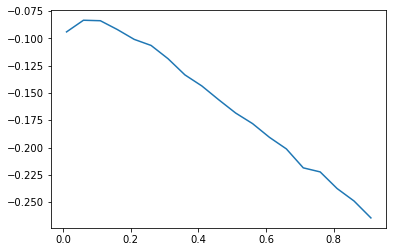

In [618]:
plt.plot(np.arange(0.01,0.96,0.05), results)
best_mc_eps = np.arange(0.01,0.96,0.05)[np.argmax(results)]
print('Лучшая eps для Monte Carlo Control: ', np.round(best_mc_eps, 5))

In [619]:
results = list()

for gamma in tqdm(np.arange(0.1,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double_update_calc(gamma=gamma)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая gamma для Q-обучения:  0.15


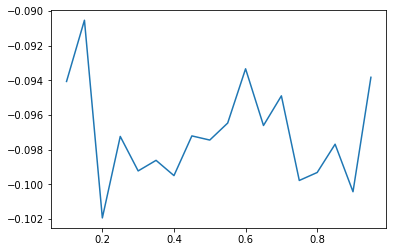

In [620]:
plt.plot(np.arange(0.1,1,0.05), results)
best_gamma = np.arange(0.1,1,0.05)[np.argmax(results)]
print('Лучшая gamma для Q-обучения: ', np.round(best_gamma, 5))

In [621]:
results = list()

for alpha in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double_update_calc(gamma=best_gamma, alpha=alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая alpha для Q-обучения:  0.35


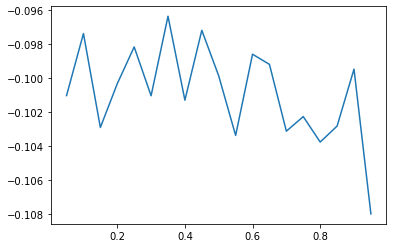

In [622]:
plt.plot(np.arange(0.05,1,0.05), results)
best_alpha = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая alpha для Q-обучения: ', np.round(best_alpha, 5))

In [623]:
results = list()

for eps in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double_update_calc(gamma=best_gamma, alpha=best_alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round(eps)

        accum += q_learn.reward
        rewards.append(reward)
        average_rewards.append(accum / (i + 1))

    results.append(average_rewards[-1])

Лучшая eps для Q-обучения:  0.1


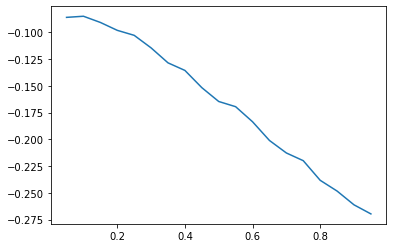

In [624]:
plt.plot(np.arange(0.05,1,0.05), results)
best_eps = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая eps для Q-обучения: ', np.round(best_eps, 5))

In [625]:
accum = 0
mc_control_rewards = list()
mc_control_average_rewards = list()
best_mc_gamma = 0.65
best_mc_eps = 0.06
    
mc_control = MC_Control_use_ace_double_calc(gamma=best_mc_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    mc_control.sample_round(best_mc_eps)

    accum += mc_control.reward
    mc_control_rewards.append(mc_control.reward)
    mc_control_average_rewards.append(accum / (i + 1))

In [626]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.35
best_gamma = 0.15

best_eps = 0.1


q_learn = Q_learning_use_ace_double_update_calc(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)

    accum += q_learn.reward
    q_learn_rewards.append(q_learn.reward)
    q_learn_average_rewards.append(accum / (i + 1))

Стратегия для Q-обучения с подсчетом карт 

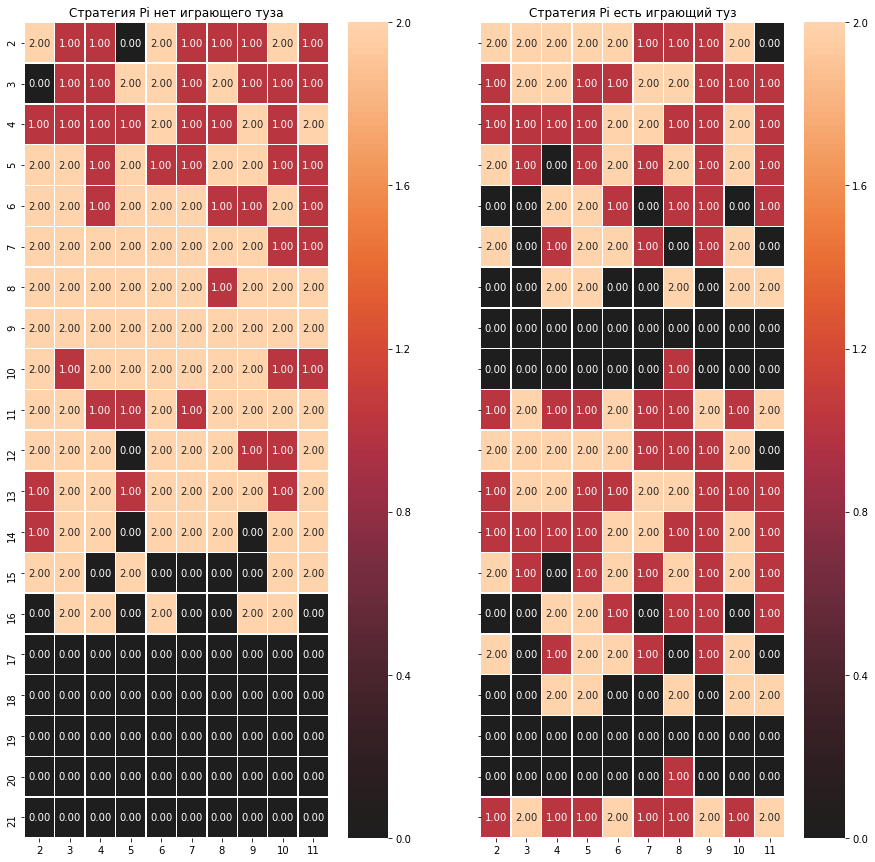

In [627]:
pi_func(q_learn.Q)

Стратегия для Monte Carlo Control с подсчетом карт 

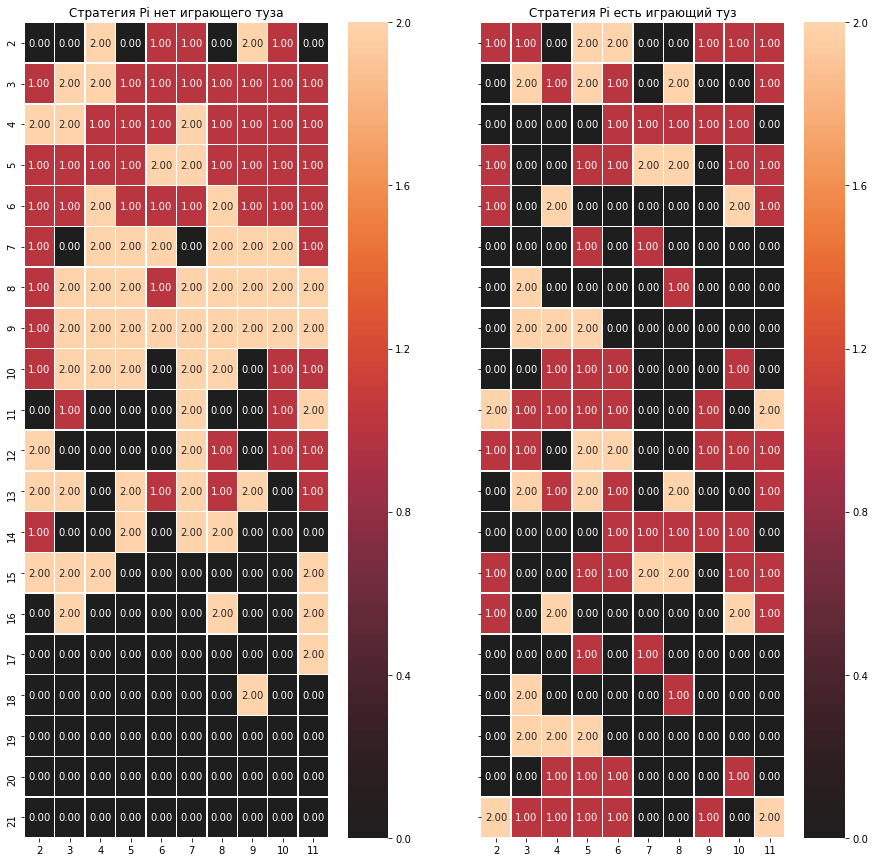

In [628]:
pi_func(mc_control.Q)

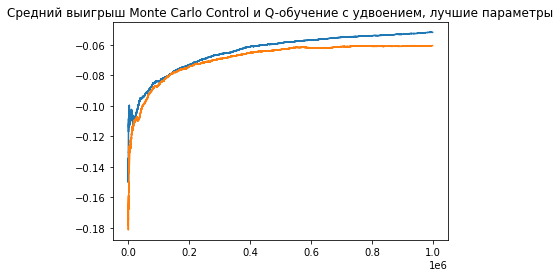

In [629]:
plt.title('Средний выигрыш Monte Carlo Control и Q-обучение с удвоением, лучшие параметры')
ax = plt.plot(mc_control_average_rewards[1000:])
ax = plt.plot(q_learn_average_rewards[1000:])

## Часть четвёртая, опциональная

Ну и напоследок ещё парочка опциональных заданий за дополнительные баллы.

Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. найти или обучить вероятности переходов между состояниями.

Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!

#### бонус. Сплит

Попробуем теперь обучиться со сплитом

In [517]:
from copy import deepcopy

class Q_learning_use_ace_double_update_calc_split(Q_learning_use_ace_double_update_calc):
    def __init__(self, alpha = 0.1, gamma = 0.9):
        self.env = BlackjackEnv()
        self.alpha = alpha
        self.gamma = gamma
        self.reward = 0
        self.Q = {
            (state, action, use_ace, dealer, heat) : 0 for heat in (0,1,2) for dealer in np.arange(2, 12) for use_ace in (0, 1) for action in (0, 1, 2) for state in (np.arange(2, 22))
        }
        
        for i in np.arange(2, 12):
            for j in (0, 1, 2):
                self.Q[(21, 0, 0, i, j)] = 1
                self.Q[(21, 0, 1, i, j)] = 1
        
        self.player = BlackjackPlayer()
        self.dealer = BlackjackPlayer()

        self.current_state = 0
        self.state_action_history = list()     
        
    def next_step(self, eps):
        next_action = list()
        double = list()
        heat = list()
        exp_flag = list()
        to_split = list()
        obs = list()
        
        for i in range(len(self.env.player)):
            obs.append(True)
            heat.append(0)
            exp_flag.append(0)
            to_split.append(0)
            next_action.append(0)
            double.append(0)        

        not_splitted_flag = False
        while not not_splitted_flag:
            for i in range(len(self.env.player)):
                self.current_state = sum_hand(self.env.player[i])                
                if sum_hand(self.env.player[i]) < 22:
                    use_ace = usable_ace(self.env.player[i])                    
                    try:
                        to_split[i] = 1
                    except Exception:
                        to_split.append(1)

                    if self.env.give_current_score() <= 0:
                        try:
                            heat[i] = 0
                        except Exception:
                            heat.append(0)
                    elif self.env.give_current_score() < 5:
                        try:
                            heat[i] = 1
                        except Exception:
                            heat.append(1)
                    else:
                        try:
                            heat[i] = 2
                        except Exception:
                            heat.append(2)

                    self.current_state = sum_hand(self.env.player[i])   
                    
                    if np.random.random() < eps:
                        next_action.append(np.random.randint(0, 2))
                        try:
                            exp_flag[i] = 1
                        except Exception:
                             exp_flag.append(1)
                        if next_action[i] == 1:
                             coin = np.random.randint(0, 2)
                             try:
                                double[i] = coin
                             except Exception:
                                double.append(coin)
                        else:
                             try:
                                double[i] = 0
                             except Exception:
                                double.append(0)
                                
                
                    else:
                        hit = self.Q[(self.current_state, 1, use_ace, sum_hand([self.env.dealer[0]]), heat[i])]
                        hit_minus_ace = self.Q[(self.current_state - 10 * use_ace, 1, use_ace, sum_hand([self.env.dealer[0]]), heat[i])]
                        stand = self.Q[(self.current_state, 0, use_ace, sum_hand([self.env.dealer[0]]), heat[i])]
                        stand_minus_ace = self.Q[(self.current_state - 10 * use_ace, 0, use_ace, sum_hand([self.env.dealer[0]]), heat[i])]
                        double_ = self.Q[(self.current_state, 2, use_ace, sum_hand([self.env.dealer[0]]), heat[i])]
                        double_minus_ace = self.Q[(self.current_state - 10 * use_ace, 2, use_ace, sum_hand([self.env.dealer[0]]), heat[i])]


                        action_dict = {
                            0: 1,
                            1: 1,
                            2: 0,
                            3: 0,
                            4: 1,
                            5: 1
                        }   
                        pi_action = action_dict[np.argmax([hit, hit_minus_ace, stand, stand_minus_ace, double_, double_minus_ace])]

                        try:        
                            next_action[i] = pi_action
                        except Exception:
                            next_action.append(pi_action)

                        if pi_action > 3:
                            try:
                                double[i] = 1
                            except Exception:
                                double.append(1)
                        else:
                            try:
                                double[i] = 0
                            except Exception:
                                double.append(0)  
            
                        if obs[i]:
                            try:
                                self.state_action_history[i].append((sum_hand(self.env.player[i]), next_action[i] + double[i], use_ace, sum_hand([self.env.dealer[0]]), heat[i]))
                            except Exception:
                                self.state_action_history.append((sum_hand(self.env.player[i]), next_action[i] + double[i], use_ace, sum_hand([self.env.dealer[0]]), heat[i]))

            obs, reward, game_over_flag, self.state_action_history = self.env.resplit(to_split, self.state_action_history)
            if True not in obs:
                not_splitted_flag = True
                
         
        state, reward, game_over_flag, _ = self.env.step(next_action, double)
        
        return (game_over_flag, reward)    

    def sample_round(self, eps = 0.2):
        self.env.reset()
        self.state_action_history = [list()]
        self.current_state = sum_hand(self.env.player[0])
        
        end_action_flag = False
        while not end_action_flag:
            game_over, reward = self.next_step(eps)
            if False not in game_over:
                self.reward = deepcopy(reward)
                for j in range(len(self.state_action_history)):
                    self.player.points.append(sum_hand(self.env.player[j]))
                    self.dealer.points.append(sum_hand(self.env.dealer))
                    self.player.hands.append(self.env.player[j])
                    self.dealer.hands.append(self.env.dealer)
                    self.player.reward.append(reward[j])
                    self.dealer.reward.append(-1 * reward[j])

                    double_reward_update_flag = True
                    for i in reversed(self.state_action_history[j]):
                        reward[j] = self.Q[i] + self.alpha * (reward[j] - self.gamma * self.Q[i])
                        self.Q[i] = reward[j]
                        if i[2] == 1:
                            self.Q[(i[0] - 10, i[1], i[2], i[3], i[4])] = reward[j] 
                        if double_reward_update_flag and i[1] == 1:
                            self.Q[(i[0], 2, i[2], i[3], i[4])] = reward[j] * 2
                            if i[2] == 1:
                                self.Q[(i[0] - 10, 2, i[2], i[3], i[4])] = reward[j] * 2
                            double_reward_update_flag = False    

                    end_action_flag = True    

In [532]:
results = list()

for gamma in tqdm(np.arange(0.1,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double_update_calc_split(gamma=gamma)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += sum(q_learn.reward)
        rewards.append(sum(q_learn.reward))
        average_rewards.append(accum / (i + 1))
    
    results.append(average_rewards[-1])

Лучшая gamma для Q-обучения:  0.9


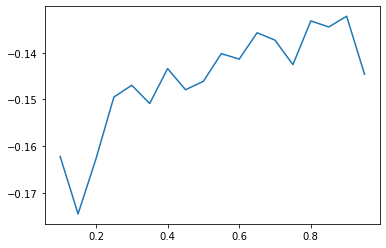

In [533]:
plt.plot(np.arange(0.1,1,0.05), results)
best_gamma = np.arange(0.1,1,0.05)[np.argmax(results)]
print('Лучшая gamma для Q-обучения: ', np.round(best_gamma, 5))

In [534]:
results = list()

for alpha in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double_update_calc_split(gamma=best_gamma, alpha=alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round()

        accum += sum(q_learn.reward)
        rewards.append(sum(q_learn.reward))
        average_rewards.append(accum / (i + 1))
    
    results.append(average_rewards[-1])

Лучшая alpha для Q-обучения:  0.15


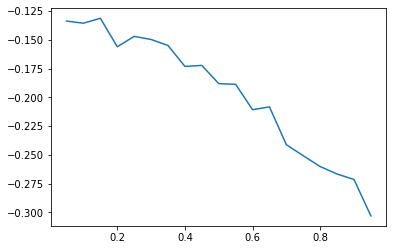

In [535]:
plt.plot(np.arange(0.05,1,0.05), results)
best_alpha = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая alpha для Q-обучения: ', np.round(best_alpha, 5))

In [536]:
results = list()

for eps in tqdm(np.arange(0.05,1,0.05)):
    accum = 0
    rewards = list()
    average_rewards = list()
    
    q_learn = Q_learning_use_ace_double_update_calc_split(gamma=best_gamma, alpha=best_alpha)

    n_steps = 100000

    for i in range(n_steps):
        q_learn.sample_round(eps)

        accum += sum(q_learn.reward)
        rewards.append(sum(q_learn.reward))
        average_rewards.append(accum / (i + 1))
    
    results.append(average_rewards[-1])

Лучшая eps для Q-обучения:  0.05


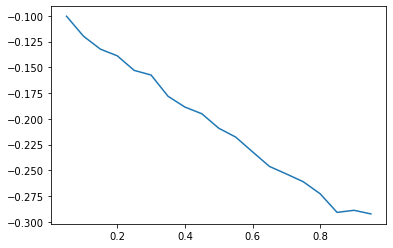

In [537]:
plt.plot(np.arange(0.05,1,0.05), results)
best_eps = np.arange(0.05,1,0.05)[np.argmax(results)]
print('Лучшая eps для Q-обучения: ', np.round(best_eps, 5))

In [538]:
accum = 0
mc_control_rewards = list()
mc_control_average_rewards = list()
best_mc_gamma = 0.65
best_mc_eps = 0.51
    
mc_control = MC_Control_use_ace_double_calc_split(gamma=best_mc_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    mc_control.sample_round(best_mc_eps)

    accum += sum(mc_control.reward)
    mc_control_rewards.append(sum(mc_control.reward))
    mc_control_average_rewards.append(accum / (i + 1))

In [539]:
accum = 0
q_learn_rewards = list()
q_learn_average_rewards = list()
best_alpha = 0.15
best_gamma = 0.9

best_eps = 0.05
last_eps = 0.01

delta_eps = best_eps - last_eps

q_learn = Q_learning_use_ace_double_update_calc_split(alpha=best_alpha, gamma=best_gamma)

n_steps = 1000000

for i in tqdm(range(n_steps)):
    q_learn.sample_round(best_eps)
    
    if (i + 1) % 100000 == 0:
        best_eps -= delta_eps / 10

    accum += sum(q_learn.reward)
    q_learn_rewards.append(sum(q_learn.reward))
    q_learn_average_rewards.append(accum / (i + 1))

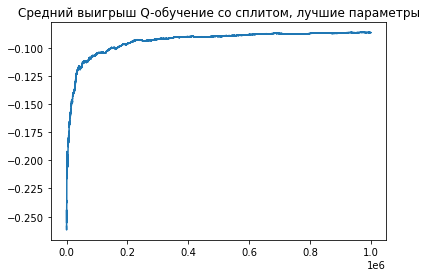

In [546]:
plt.title('Средний выигрыш Q-обучение со сплитом, лучшие параметры')
ax = plt.plot(q_learn_average_rewards[1000:])

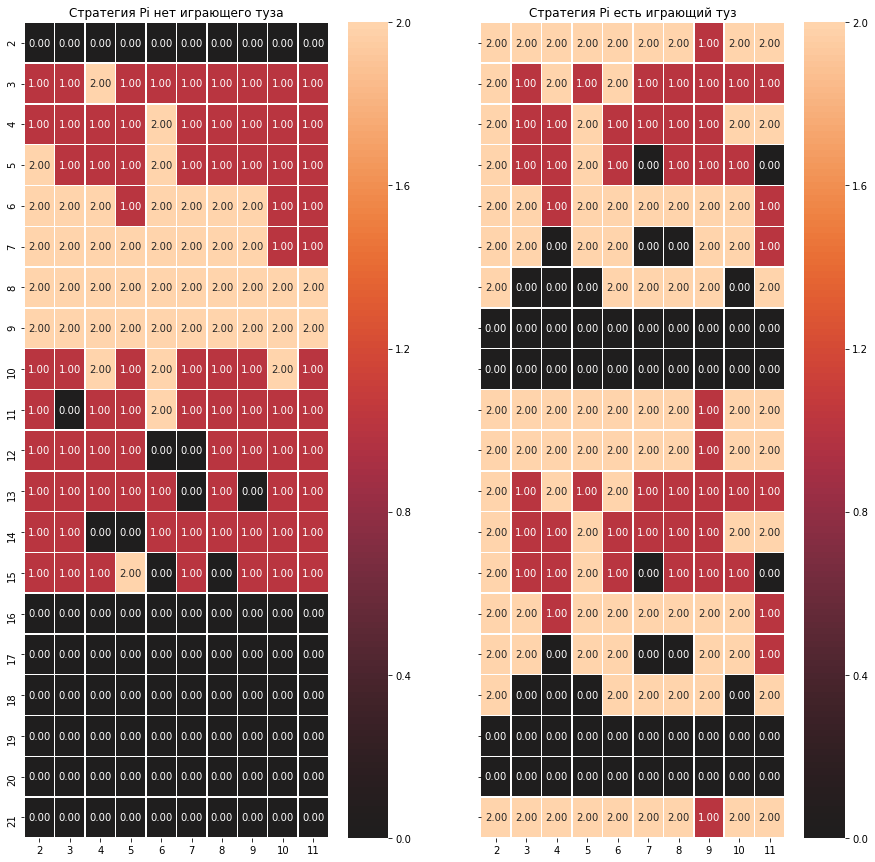

In [545]:
pi_func(q_learn.Q)